In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from scipy.sparse import csr_matrix as smatrix
import scipy.sparse.linalg as splinalg
import os
import sys
sources = os.path.join(os.pardir, "modules")
if sources not in sys.path:
    sys.path.insert(0, sources)
import fem


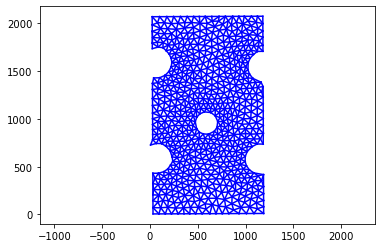

In [2]:
Ns=10
inp='../data/dic-coarse.res'
pix2m=25.e-6; # pixel to m conversion
thickness=3e-3 # speimen thicness in m
dL=100

(X,conn)=fem.readDICmesh(inp)
model=fem.FEModel()
model.X=X
model.conn=conn
model.Assemble()
W=model.W
B=model.B
Xg=0.5*(X[conn[:,0]]+X[conn[:,1]])
Nnodes=X.shape[0]
Nelems=conn.shape[0]
plt.plot(X[conn,0].T,X[conn,1].T,'b-');
plt.axis('equal');

10.0
For load factor  1e-01  after  6 iterations dU/U= 2.0184789964149667e-07
20.0
For load factor  2e-01  after  6 iterations dU/U= 8.736081860341016e-07
30.000000000000004
For load factor  3.0000000000000004e-01  after  7 iterations dU/U= 1.3117413777985892e-07
40.0
For load factor  4e-01  after  7 iterations dU/U= 3.459174595048927e-07
50.0
For load factor  5e-01  after  7 iterations dU/U= 7.414917503515041e-07
60.0
For load factor  6e-01  after  8 iterations dU/U= 1.675886484471263e-07
70.0
For load factor  7.000000000000001e-01  after  8 iterations dU/U= 3.2969350581357916e-07
80.0
For load factor  8e-01  after  8 iterations dU/U= 5.908552701265986e-07
90.0
For load factor  9e-01  after  8 iterations dU/U= 9.849791951560575e-07
100.0
For load factor  1e+00  after  9 iterations dU/U= 3.2041808080591445e-07


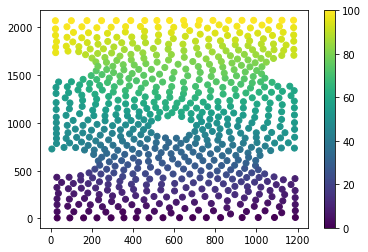

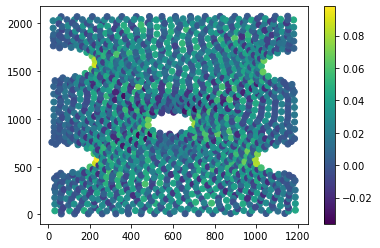

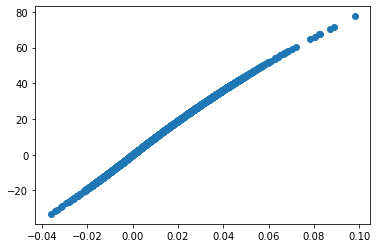

In [3]:
top=X[:,1]>max(X[:,1])*0.99
bot=X[:,1]<max(X[:,1])*0.01

nodes_index=np.arange(Nnodes)
top_nodes=nodes_index[top]
ntop=top_nodes.size
free=np.logical_not(np.logical_or(top, bot))
free_nodes=nodes_index[free]
nfree=free_nodes.size
free_ddls=np.r_[free_nodes,free_nodes+Nnodes]


Fext=np.zeros(2*Nnodes)
Uimp=np.zeros(2*Nnodes)
Uimp[top_nodes+Nnodes]=1
U=np.zeros(2*Nnodes)
L=max(X[:,1])-min(X[:,1])

dS=2e8/0.2*pix2m
K=(B.T)*(W*B*dS)        

# kg.m.s^-2/m^2=kg.s^-2/m

dU=np.zeros(2*Nnodes)
E=B.dot(U)
lfs=np.arange(1/Ns,1+1/Ns,1/Ns)
itmax=100
crit=1.e-6
for lf in lfs:
    print(lf*dL)
    U[top_nodes+Nnodes]=dL*lf
    iter=0
    ndU=1
    while (ndU > crit)&(iter<itmax):
        E=B.dot(U)
        S=2e8*(1-np.exp(-np.abs(E)/0.2))*np.sign(E)*pix2m
        Fint=(B.T).dot(W.dot(S))
        Res=Fext-Fint
        dU[free_ddls]=splinalg.spsolve(K[np.ix_(free_ddls,free_ddls)],Res[free_ddls])
        U+=dU
        iter+=1
        ndU=np.linalg.norm(dU)/np.linalg.norm(U)
        #print(ndU)
    print('For load factor ',lf,' after ',iter,'iterations', 'dU/U=',ndU)
ff=plt.figure()
plt.scatter(X[:,0],X[:,1],c=U[Nnodes::])
plt.colorbar()
ff=plt.figure()
plt.scatter(Xg[:,0],Xg[:,1],c=E)
plt.colorbar()

ff=plt.figure()
plt.plot(E,S/pix2m*1.e-6,'o')


In [4]:
Fres=sum(Fint[top_nodes+Nnodes])*thickness
print(Fres)

52.67306774596358


In [5]:
np.savez('fem-from-dic',U=U,Fres=Fres,Sref=S/pix2m)
